# Import

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

# Database Connection

In [2]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

# Query for Data Extraction

In [3]:
query1 = """select created::date, id, order_status, ordered_via, user_id, order_amount from sales_userorderdata;"""

query2 = """select created::date, order_id, product_name, quantity from sales_userorderproductsizedata"""

# Derive Required Data

In [4]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "order_status", "order_channel", "user_id", "order_amount"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["created", "order_id", "product_name", "quantity"]
f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1
#e2['order_id']=e2['order_id_x']
y2=e2.groupby('OrderDate').agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        ActiveUsersCounts=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
        NewTrxns=pd.NamedAgg(column='New', aggfunc='sum'),
    RepearTrxns=pd.NamedAgg(column='Repeat', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e[e['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e[e['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

ordered_via_values = e['order_channel'].unique()
for ordered_via in ordered_via_values:
    y2[f'Channel_{ordered_via}'] = 0
for ordered_via in ordered_via_values:
    orders_by_channel = e[e['order_channel'] == ordered_via].groupby('OrderDate').size()
    y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate (in Percentage)']=y2['CancellationCount']*100/y2['OrderCounts']
y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

metrics=['OrderCounts','ActiveUsersCounts','NewUserCount','RepeatUserCount','TotalOrderValue','AOV','ASP','NewOrderRatio','SKUsperOrder','UnitsperOrder','DeliveryCount','CancellationCount', 'CancellationRate']
for ordered_via in ordered_via_values:
    metric = f'Channel_{ordered_via}'
    metrics.append(metric)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_4268\1744246450.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_4268\1744246450.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


In [5]:
y2

,OrderDate,OrderCounts,ActiveUsersCounts,TotalOrderValue,AOV,NewTrxns,RepearTrxns,Quantity,SKUCount,CancellationCount,...,Channel_Android App,Channel_IOS App,Channel_Web App,NewOrderRatio,RepeatOrderRatio,UnitsperOrder,SKUsperOrder,ASP,CancellationRate (in Percentage),RepeatUserCount
0,2019-04-01,151,143,140902.42,933.128609,143,8,1851.0,489.0,6.0,...,151.0,0.0,0.0,0.947020,0.052980,12.258278,3.238411,76.122323,3.973510,0
1,2019-04-02,207,199,267573.00,1292.623188,185,22,2780.0,870.0,10.0,...,207.0,0.0,0.0,0.893720,0.106280,13.429952,4.202899,96.249281,4.830918,14
2,2019-04-03,256,240,270019.12,1054.762187,215,41,2662.0,880.0,13.0,...,256.0,0.0,0.0,0.839844,0.160156,10.398438,3.437500,101.434681,5.078125,25
3,2019-04-04,218,210,265322.04,1217.073578,177,41,2454.0,791.0,2.0,...,218.0,0.0,0.0,0.811927,0.188073,11.256881,3.628440,108.118191,0.917431,33
4,2019-04-05,200,193,312976.75,1564.883750,155,45,4942.0,828.0,4.0,...,200.0,0.0,0.0,0.775000,0.225000,24.710000,4.140000,63.329978,2.000000,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2023-10-21,2,2,49.00,24.500000,2,0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.000000,0.000000,0.500000,0.500000,49.000000,0.000000,0
1625,2023-11-01,4,1,588.00,147.000000,0,4,4.0,4.0,4.0,...,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000,147.000000,100.000000,1
1626,2023-11-03,1,1,154.00,154.000000,0,1,1.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000,154.000000,100.000000,1
1627,2023-11-08,2,1,236.00,118.000000,0,2,2.0,2.0,2.0,...,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000,118.000000,100.000000,1


In [6]:
e2

,created,order_id,order_status,order_channel,user_id,order_amount,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat
0,2023-05-09,659551,Delivered,Whatsapp,47854,588.0,2023-05-09,NaN,NaN,2023-05-09,2022-05-20,2.0,2.0,6.0,0,1
1,2022-11-17,597624,Cancelled,Whatsapp,47854,206.0,2022-11-17,173.0,382.0,2023-05-09,2022-05-20,1.0,1.0,2.0,0,1
2,2022-05-20,531696,Cancelled,Whatsapp,47854,186.0,2022-05-20,181.0,20.0,2023-05-09,2022-05-20,1.0,1.0,1.0,1,0
3,2022-11-18,598007,Delivered,Whatsapp,47854,371.0,2022-11-18,182.0,-185.0,2023-05-09,2022-05-20,1.0,1.0,3.0,0,1
4,2023-01-10,617113,Delivered,Whatsapp,47854,371.0,2023-01-10,53.0,0.0,2023-05-09,2022-05-20,1.0,1.0,4.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569427,2023-05-14,661112,Delivered,Android App,56795,4654.0,2023-05-14,NaN,NaN,2023-05-14,2023-05-14,6.0,35.0,1.0,1,0
569428,2023-05-15,661345,Delivered,Android App,56810,1947.0,2023-05-15,NaN,NaN,2023-05-15,2023-05-15,11.0,14.0,1.0,1,0
569429,2023-05-15,661463,Delivered,Android App,56823,1162.0,2023-05-15,NaN,NaN,2023-05-15,2023-05-15,2.0,9.0,1.0,1,0
569430,2023-05-15,661486,Delivered,IOS App,56824,17305.0,2023-05-15,NaN,NaN,2023-05-15,2023-05-15,7.0,102.0,1.0,1,0


In [7]:
# y2 = y2[["order_date", "ActiveUsersCounts", "NewUserCount", "RepeatUserCount", "AOV", "UnitsperOrder"]]
# y2
len(metrics)

17

# Input TimeFrame and Detect Anomalies

In [11]:
# year = 2022
# month = 8

# num_days = calendar.monthrange(year, month)[1]
# dates = [f'{year}-{month:02d}-{day:02d}' for day in range(1, num_days + 1)]

# Date Filter
start_date = '2023-05-01'
end_date = '2023-08-30'

date_range = pd.date_range(start=start_date, end=end_date)

dates = [date.strftime('%Y-%m-%d') for date in date_range]
parameters = metrics #["ActiveUsersCounts", "NewUserCount", "RepeatUserCount", "AOV", "UnitsperOrder"]

def missing_dates(dates, y2)
    df_new = pd.DataFrame(columns = ["OrderDate"])
    df_new["OrderDate"] = dates
    df_new["OrderDate"] = pd.to_datetime(df_new["OrderDate"])
    
    df_updated = pd.merge(df_new, y2, on='OrderDate', how='outer')
    df_updated = df_updated.fillna(0)
    return df_updated

y2_no_missing = missing_dates(dates, y2)

main = {}
data = []

for parameter in parameters:
    isanomaly_1, isanomaly_2, isanomaly_3 = [], [], []
    anomaly_tag_1, anomaly_tag_2, anomaly_tag_3 = [], [], []
    percentiles_1, percentiles_2, percentiles_3 = [], [], []
    percentiles_05_1, percentiles_05_2, percentiles_05_3 = [], [], []
    percentiles_95_1, percentiles_95_2, percentiles_95_3 = [], [], []
    data = []
    print("Parameter: ", parameter)
    working_df = y2_no_missing[["OrderDate", parameter]]
    sample_df_1 = working_df[working_df["OrderDate"].isin(dates)]
    for date in dates:
        date_main = datetime.strptime(date, '%Y-%m-%d')
        i = working_df.loc[working_df['OrderDate'] == date_main].index[0]
        if i > 13:
            window = working_df[parameter].iloc[i - 13 : i + 1]
            percentile = (window - window.min()) / (window.max() - window.min()) * 100
            if percentile.iloc[13] < 5:
                anomaly_tag_1.append("Lower")
                isanomaly_1.append("Yes")
            elif percentile.iloc[13] > 95:
                anomaly_tag_1.append("Higher")
                isanomaly_1.append("Yes")
            else:
                isanomaly_1.append("No")
                anomaly_tag_1.append("-")
            percentiles_1.append(percentile.iloc[13])
            percentiles_05_1.append(percentile.quantile(0.10))
            percentiles_95_1.append(percentile.quantile(0.90))
        else:
            isanomaly_1.append("Not Enough Data")
            anomaly_tag_1.append("Not Enough Data")
            percentiles_1.append("Not Enough Data")
            percentiles_05_1.append("Not Enough Data")
            percentiles_95_1.append("Not Enough Data")

        if i > 90:
            window_dates = [date_main - timedelta(days=i*7) for i in range(13)]
            window = working_df[parameter].iloc[i + 1 : i - 85 : -7]
            sample_df_2 = working_df[working_df["OrderDate"].isin(dates)]
            percentile = (window - window.min()) / (window.max() - window.min()) * 100
            if percentile.iloc[0] < 5:
                anomaly_tag_2.append("Lower")
                isanomaly_2.append("Yes")
            elif percentile.iloc[0] > 95:
                anomaly_tag_2.append("Higher")
                isanomaly_2.append("Yes")
            else:
                isanomaly_2.append("No")
                anomaly_tag_2.append("-")
            percentiles_2.append(percentile.iloc[0])
            percentiles_05_2.append(percentile.quantile(0.10))
            percentiles_95_2.append(percentile.quantile(0.90))
        else:
            isanomaly_2.append("Not Enough Data")
            anomaly_tag_2.append("Not Enough Data")
            percentiles_2.append("Not Enough Data")
            percentiles_05_2.append("Not Enough Data")
            percentiles_95_2.append("Not Enough Data")

        if i > 90:
            window_1 = working_df[parameter].iloc[i - 13 : i + 1]
            window_2 = working_df[parameter].iloc[i : i - 85 : -7]
            window = pd.concat([window_1, window_2[2:]], ignore_index=True)
            sample_df_3 = working_df[working_df["OrderDate"].isin(dates)]
            percentile = (window - window.min()) / (window.max() - window.min()) * 100
            if percentile.iloc[13] < 5:
                anomaly_tag_3.append("Lower")
                isanomaly_3.append("Yes")
            elif percentile.iloc[13] > 95:
                anomaly_tag_3.append("Higher")
                isanomaly_3.append("Yes")
            else:
                isanomaly_3.append("No")
                anomaly_tag_3.append("-")
            percentiles_3.append(percentile.iloc[13])
            percentiles_05_3.append(percentile.quantile(0.10))
            percentiles_95_3.append(percentile.quantile(0.90))
        else:
            isanomaly_3.append("Not Enough Data")
            anomaly_tag_3.append("Not Enough Data")
            percentiles_3.append("Not Enough Data")
            percentiles_05_3.append("Not Enough Data")
            percentiles_95_3.append("Not Enough Data")


    sample_df_1["Is_Anomaly?"] = isanomaly_1
    sample_df_1["Anomaly_Tag"] = anomaly_tag_1
    sample_df_1['Percentile'] = percentiles_1
    sample_df_1['5th_Percentile'] = percentiles_05_1
    sample_df_1['95th_Percentile'] = percentiles_95_1
    sample_df_2["Is_Anomaly?"] = isanomaly_2
    sample_df_2["Anomaly_Tag"] = anomaly_tag_2
    sample_df_2['Percentile'] = percentiles_2
    sample_df_2['5th_Percentile'] = percentiles_05_2
    sample_df_2['95th_Percentile'] = percentiles_95_2
    sample_df_3["Is_Anomaly?"] = isanomaly_3
    sample_df_3["Anomaly_Tag"] = anomaly_tag_3
    sample_df_3['Percentile'] = percentiles_3
    sample_df_3['5th_Percentile'] = percentiles_05_3
    sample_df_3['95th_Percentile'] = percentiles_95_3
    sample_df_1['OrderDate'] = pd.to_datetime(sample_df_3['OrderDate'])
    sample_df_2['OrderDate'] = pd.to_datetime(sample_df_3['OrderDate'])
    sample_df_3['OrderDate'] = pd.to_datetime(sample_df_3['OrderDate'])
    data.append(sample_df_1)
    data.append(sample_df_2)
    data.append(sample_df_3)
    main[parameter] = data

,OrderDate,OrderCounts,ActiveUsersCounts,TotalOrderValue,AOV,NewTrxns,RepearTrxns,Quantity,SKUCount,CancellationCount,...,Channel_Android App,Channel_IOS App,Channel_Web App,NewOrderRatio,RepeatOrderRatio,UnitsperOrder,SKUsperOrder,ASP,CancellationRate (in Percentage),RepeatUserCount
0,2023-05-01,444,398,468543.0,1055.277027,21,423,3128.0,1372.0,71.0,...,139.0,16.0,13.0,0.047297,0.952703,7.045045,3.090090,149.789962,15.990991,377
1,2023-05-02,429,403,495670.0,1155.407925,26,403,3923.0,1412.0,86.0,...,109.0,30.0,9.0,0.060606,0.939394,9.144522,3.291375,126.349732,20.046620,377
2,2023-05-03,380,367,438413.0,1153.718421,18,362,2689.0,1229.0,60.0,...,99.0,19.0,5.0,0.047368,0.952632,7.076316,3.234211,163.039420,15.789474,349
3,2023-05-04,378,351,389528.0,1030.497354,20,358,2598.0,1239.0,71.0,...,110.0,19.0,4.0,0.052910,0.947090,6.873016,3.277778,149.933795,18.783069,331
4,2023-05-05,360,336,343502.0,954.172222,24,336,2367.0,1066.0,69.0,...,116.0,8.0,4.0,0.066667,0.933333,6.575000,2.961111,145.121251,19.166667,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2023-10-21,2,2,49.0,24.500000,2,0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.000000,0.000000,0.500000,0.500000,49.000000,0.000000,0
1625,2023-11-01,4,1,588.0,147.000000,0,4,4.0,4.0,4.0,...,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000,147.000000,100.000000,1
1626,2023-11-03,1,1,154.0,154.000000,0,1,1.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000,154.000000,100.000000,1
1627,2023-11-08,2,1,236.0,118.000000,0,2,2.0,2.0,2.0,...,0.0,0.0,0.0,0.000000,1.000000,1.000000,1.000000,118.000000,100.000000,1


# Table Form

In [49]:
# ['OrderCounts','ActiveUsersCounts','NewUserCount','RepeatUserCount','TotalOrderValue','AOV','ASP','NewOrderRatio','SKUsperOrder','UnitsperOrder','DeliveryCount','CancellationCount', 'CancellationRate']

parameter = "OrderCounts"
month_data = main[parameter][2]
anomaly_data = main[parameter][2][main[parameter][0]["Is_Anomaly?"] == "Yes"]

anomaly_data_high = main[parameter][2][(main[parameter][2]['Is_Anomaly?'] == 'Yes') & (main[parameter][2]['Anomaly_Tag'] == 'Higher')]
anomaly_data_low = main[parameter][2][(main[parameter][2]['Is_Anomaly?'] == 'Yes') & (main[parameter][2]['Anomaly_Tag'] == 'Lower')]

result_high = anomaly_data_high.groupby(anomaly_data_high['OrderDate'].dt.strftime('%Y-w%U')).agg(
    High_Anomaly_Dates=pd.NamedAgg(column=month_data.columns[0], aggfunc=list),
    High_Anomaly_Count=pd.NamedAgg(column=month_data.columns[3], aggfunc=lambda x: (x == 'Higher').sum()),
    High_Anomaly_Values = pd.NamedAgg(column=month_data.columns[1], aggfunc=list)
)

for i in range (len(result_high)):
    x = [x.strftime("%Y-%m-%d") for x in result_high["High_Anomaly_Dates"][i]]
    res = ", ".join(x)
    result_high["High_Anomaly_Dates"][i] = res
    y = [str(x) for x in result_high["High_Anomaly_Values"][i]]
    res = ", ".join(y)
    result_high["High_Anomaly_Values"][i] = res

result_low = anomaly_data_low.groupby(anomaly_data_low['OrderDate'].dt.strftime('%Y-w%U')).agg(
    Low_Anomaly_Dates=pd.NamedAgg(column=month_data.columns[0], aggfunc=list),
    Low_Anomaly_Count=pd.NamedAgg(column=month_data.columns[3], aggfunc=lambda x: (x == 'Lower').sum()),
    Low_Anomaly_Values = pd.NamedAgg(column=month_data.columns[1], aggfunc=list)
)

for i in range (len(result_low)):
    x = [x.strftime("%Y-%m-%d") for x in result_low["Low_Anomaly_Dates"][i]]
    res = ", ".join(x)
    result_low["Low_Anomaly_Dates"][i] = res
    y = [str(x) for x in result_low["Low_Anomaly_Values"][i]]
    res = ", ".join(y)
    result_low["Low_Anomaly_Values"][i] = res

week_data = month_data.groupby(month_data['OrderDate'].dt.strftime('%Y-w%U')).agg(
    z=pd.NamedAgg(column=month_data.columns[1], aggfunc='sum'))
final_dataframe = pd.merge(week_data, result_high, on='OrderDate', how='left')
final_dataframe = pd.merge(final_dataframe, result_low, on='OrderDate', how='left')
final_dataframe.columns.values[0] = f"Total_{parameter}"
final_dataframe.index.name = "order_week"
final_dataframe.fillna("-", inplace=True)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_7748\3315725244.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = [x.strftime("%Y-%m-%d") for x in result_high["High_Anomaly_Dates"][i]]
C:\Users\CEPL\AppData\Local\Temp\ipykernel_7748\3315725244.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_high["High_Anomaly_Dates"][i] = res
C:\Users\CEPL\AppData\Local\Temp\ipykernel_7748\3315725244.py:19: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser

In [50]:
final_dataframe

,Total_OrderCounts,High_Anomaly_Dates,High_Anomaly_Count,High_Anomaly_Values,Low_Anomaly_Dates,Low_Anomaly_Count,Low_Anomaly_Values
order_week,,,,,,,
2023-w18,2312,-,-,-,-,-,-
2023-w19,2361,-,-,-,2023-05-07,1.0,173
2023-w20,2199,-,-,-,-,-,-
2023-w21,2244,-,-,-,2023-05-21,1.0,132
2023-w22,2219,-,-,-,2023-05-28,1.0,137
2023-w23,2137,-,-,-,-,-,-
2023-w24,2181,-,-,-,-,-,-
2023-w25,2097,-,-,-,-,-,-
2023-w26,2092,2023-07-01,1.0,391,2023-06-25,1.0,124


# Visualization

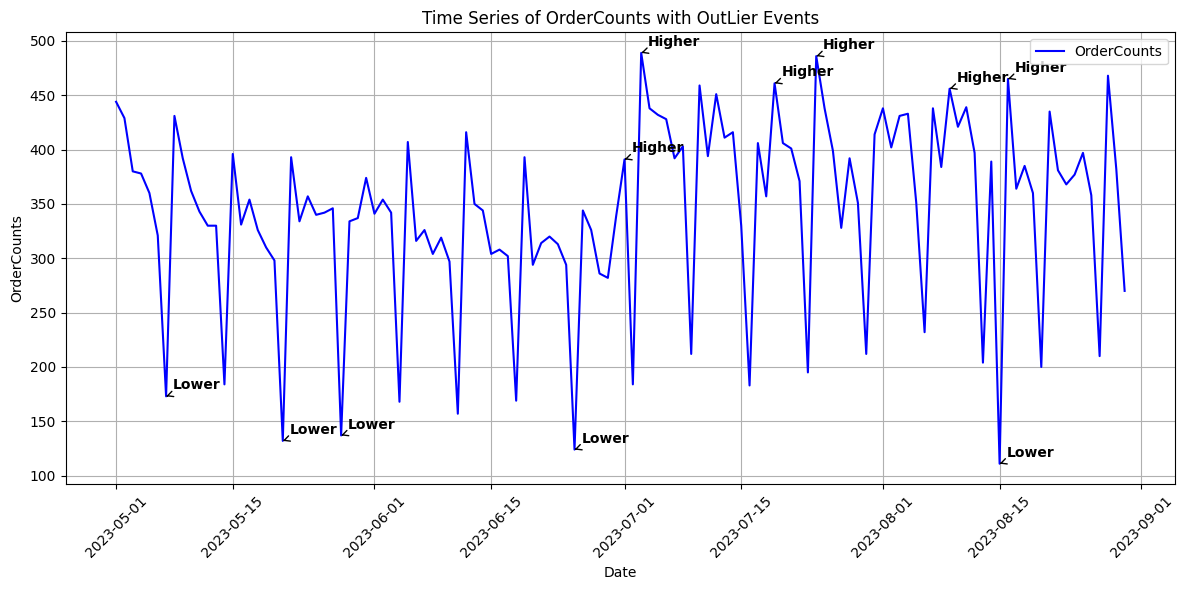

In [29]:
second_column = month_data.iloc[:, 1]
second_column_name = month_data.columns[1]

# Plot the time series of the second column
plt.figure(figsize=(12, 6))
plt.plot(month_data['OrderDate'], second_column, label=second_column_name, color='blue')

# Annotate the anomaly tags for respective dates
for i, row in month_data.iterrows():
    if row['Is_Anomaly?'] != 'No':
        plt.annotate(f'{row["Anomaly_Tag"]}', xy=(row['OrderDate'], second_column[i]),
                     xytext=(5, 5), textcoords='offset points', color='black', fontsize=10, weight='bold', arrowprops=dict(arrowstyle='->', color='black', lw=1))

plt.xlabel('Date')
plt.ylabel(second_column_name)
plt.title(f'Time Series of {second_column_name} with OutLier Events')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Alert Data

In [13]:
Higher_Percentage = []
Lower_Percentage = []
for parameter in ['OrderCounts','ActiveUsersCounts','NewUserCount','RepeatUserCount','TotalOrderValue','AOV','ASP','NewOrderRatio','SKUsperOrder','UnitsperOrder','DeliveryCount','CancellationCount', 'CancellationRate']:
    x, y = [], []
    month_data = main[parameter][0]
    
    average_no_anomaly = month_data.loc[month_data['Is_Anomaly?'] == 'No', parameter].mean()
    max_higher_anomaly = month_data.loc[month_data['Anomaly_Tag'] == 'Higher', parameter].max()
    max_higher_date = month_data[month_data[parameter] == max_higher_anomaly].OrderDate.values[0]
    min_lower_anomaly = month_data.loc[month_data['Anomaly_Tag'] == 'Lower', parameter].min()
    min_lower_date = month_data[month_data[parameter] == min_lower_anomaly].OrderDate.values[0]
    high_percent = max_higher_anomaly / average_no_anomaly * 100
    low_percent = min_lower_anomaly / average_no_anomaly * 100
    
    x.append(str(high_percent) + "%")
    x.append(max_higher_date)
    Higher_Percentage.append(x)
    y.append(str(low_percent) + "%")
    y.append(min_lower_date)
    Lower_Percentage.append(y)
    

# metrics = ["ActiveUsersCounts", "NewUserCount", "RepeatUserCount", "AOV", "UnitsperOrder"]
parameter = "CancellationRate"
i = metrics.index(parameter)
print(f"Higher Percentage for {parameter} is {Higher_Percentage[i][0]} which was on {Higher_Percentage[i][1]}")
print(f"Lower Percentage for {parameter} is {Lower_Percentage[i][0]} which was on {Lower_Percentage[i][1]}")

Higher Percentage for CancellationRate is 184.00981265548944% which was on 2023-01-26T00:00:00.000000000
Lower Percentage for CancellationRate is 70.00157146566713% which was on 2023-01-05T00:00:00.000000000
